In [41]:
from Helpers import *
from Controller import *

In [42]:
def LQG_Matrix(Duration,w1,w2,w3,w4,r1,r2,targets = [0,55],starting_point = [0,20],ForceField = [0,0],plot = True,Delay = 0,plotXhat = True,ForceFieldSpan = [0,0.6],Noise_Variance = 1e-6,newtonfunc = newtonf,newtondfunc = newtondf,Num_iter = 60):
    
    dt = Duration/Num_iter
    kdelay = int(Delay/dt)

    obj1,obj2 = newton(newtonfunc,newtondfunc,1e-8,1000,targets[0],targets[1]) #Defini les targets
    st1,st2 = newton(newtonfunc,newtondfunc,1e-8,1000,starting_point[0],starting_point[1])

    xstart = np.array([st1,0,0,st2,0,0,obj1,0,obj2,0])
    x0 = np.array([st1,0,0,st2,0,0,obj1,obj2])
    x0_with_delay = np.copy(x0)
    for _ in range(kdelay):
        x0_with_delay = np.concatenate((x0_with_delay,x0))
    Num_Var = 8
    
    #Define Weight Matrices

    R = np.array([[r1,0],[0,r2]])
    Q = np.array([[w1,0,0,0,0,0,-w1,0],[0,w2,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
             [0,0,0,w3,0,0,0,-w3],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
             [-w1,0,0,0,0,0,w1,0],[0,0,0,-w3,0,0,0,w3]])
    
    
    #Define Dynamic Matrices  

    Am = np.array([[0,1,0,0,0,0,0,0],[0,(-0.5*a1+0.025*a3)/((a1-a3)*a3),a1/((a1-a3)*a3),0,(-0.025*a1+0.5*a3)/((a1-a3)*a3),1/(a3-a1),0,0],
     [0,0,-1/tau,0,0,0,0,0],[0,0,0,0,1,0,0,0],[0,0.475/(a1-a3),-1/(a1-a3),0,-0.475/(a1-a3),1/(a1-a3),0,0],
     [0,0,0,0,0,-1/tau,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0]])

    Bm = np.transpose([[0,0,1/tau,0,0,0,0,0],[0,0,0,0,0,1/tau,0,0]])

    A = np.zeros(((kdelay+1)*Num_Var,(kdelay+1)*Num_Var))
    A[:Num_Var,:Num_Var] = Am
    A[Num_Var:,:-Num_Var] = np.identity((kdelay)*Num_Var)
    B = np.zeros(((kdelay+1)*Num_Var,2))
    B[:Num_Var] = Bm

    A_basic = np.array([[1,dt,0,0,0,0,0,0],[0,1+dt*(-0.5*a1+0.025*a3)/((a1-a3)*a3),dt*a1/((a1-a3)*a3),0,dt*(-0.025*a1+0.5*a3)/((a1-a3)*a3),dt/(a3-a1),0,0],
     [0,0,1-dt/tau,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,dt*0.475/(a1-a3),-dt/(a1-a3),0,1-dt*0.475/(a1-a3),dt/(a1-a3),0,0],
     [0,0,0,0,0,1-dt/tau,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])

    B_basic = np.transpose([[0,0,dt/tau,0,0,0,0,0],[0,0,0,0,0,dt/tau,0,0]])

    NewQ = np.zeros(((kdelay+1)*Num_Var,(kdelay+1)*Num_Var))
    NewQ[:Num_Var,:Num_Var] = Q 
    Q = NewQ

    H = np.zeros((Num_Var,(kdelay+1)*Num_Var))
    H[:,(kdelay)*Num_Var:]= np.identity(Num_Var)

    A_iter = np.zeros(((kdelay+1)*Num_Var,(kdelay+1)*Num_Var))
    A_iter[:Num_Var,:Num_Var] = A_basic
    A_iter[Num_Var:,:-Num_Var] = np.identity((kdelay)*Num_Var)
    B_iter = np.zeros(((kdelay+1)*Num_Var,2))
    B_iter[:Num_Var] = B_basic
    
    
    S = Q

    
    array_L = np.zeros((Num_iter-1,2,Num_Var*(kdelay+1)))   
    array_S = np.zeros((Num_iter,Num_Var*(kdelay+1),Num_Var*(kdelay+1))) 
    array_S[-1] = Q
    for k in range(Num_iter-1):
        L = np.linalg.inv(R+B_iter.T@S@B_iter)@B_iter.T@S@A_iter
        array_L[Num_iter-2-k] = L
        S = A_iter.T@S@(A_iter-B_iter@L)
        array_S[Num_iter-2-k] = S
        
    #print(array_L[0])
    #Feedback
    L=array_L
        
    array_x = np.zeros((Num_iter,Num_Var))
    array_xhat = np.zeros((Num_iter,Num_Var))
    y = np.zeros((Num_iter-1,Num_Var))

    array_x[0] = x0.flatten()
    array_xhat[0] = x0.flatten()
    xhat = np.copy(x0_with_delay)
    x = np.copy(x0_with_delay)

    sigma = np.identity(Num_Var*(kdelay+1))*10**-6 
    J = 0
    for k in range(Num_iter-1):
        F = ForceField if ((k*dt >= ForceFieldSpan[0]) and (k*dt < ForceFieldSpan[1])) else [0,0]
             
        _,_,Omega_measure,measure_noise = Compute_Noise(Num_Var,Noise_Variance)
        Omega_sens,motor_noise,_,_ = Compute_Noise(Num_Var*(kdelay+1),Noise_Variance)
    
        y[k] = (H@x).flatten()
        K = A_iter@sigma@H.T@np.linalg.inv(H@sigma@H.T+Omega_measure)
        sigma = Omega_sens + (A_iter - K@H)@sigma@A_iter.T
        u = - L[k].reshape(np.flip(B.shape))@xhat
        J+= u.T@R@u
        xhat = Matrix_Iteration(xhat,A,B,u,dt) + K@(y[k]-H@xhat)
        x = Matrix_Iteration(x,A,B,u+F,dt)
        array_xhat[k+1] = xhat[:Num_Var].flatten()
        array_x[k+1] = x[:Num_Var].flatten()

        #print(array_x[k-1,2],((array_x[k]-array_x[k-1])/dt)[1])   

#Plot
    J+= x.T@Q@x
    x0 = xstart
    if plotXhat :
        x_nonlin = array_xhat.T[:,1:][:,::1]
        X = np.cos(x_nonlin[0]+x_nonlin[3])*33+np.cos(x_nonlin[0])*30
        Y = np.sin(x_nonlin[0]+x_nonlin[3])*33+np.sin(x_nonlin[0])*30
        plt.plot(X,Y,color = "black",label = "Estimate",linewidth = .8,linestyle = "--")
        plt.axis("equal")
        plt.scatter([targets[0]],[targets[1]])
        

    x_nonlin = array_x.T[:,1:][:,::1]
    X = np.cos(x_nonlin[0]+x_nonlin[3])*33+np.cos(x_nonlin[0])*30
    Y = np.sin(x_nonlin[0]+x_nonlin[3])*33+np.sin(x_nonlin[0])*30

    if plot:
        plt.plot(X,Y,color = "green",label = "LQG_ExpoMatrix",linewidth = .8)
        plt.axis("equal")
        plt.scatter([targets[0]],[targets[1]])
        plt.grid(linestyle='--')

    return array_xhat,J

def Matrix_Iteration(x,A,B,u,dt):
    ExpA = expm(A*dt)
    n, m = A.shape[0], B.shape[1]
    block_matrix = np.block([[A, B], [np.zeros((m, n)), np.zeros((m, m))]])
    exp_block = expm(block_matrix * dt)
    ExpB = exp_block[:n, n:]
    return ExpA @ x + ExpB @ u


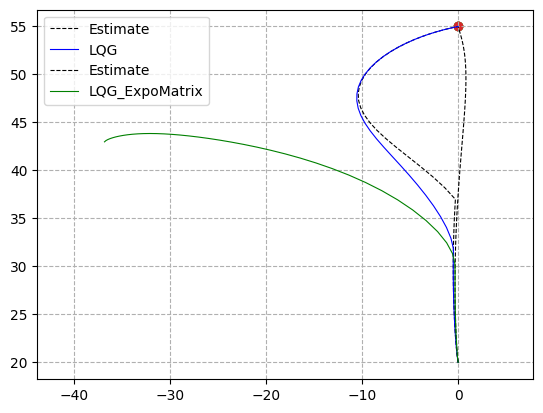

In [43]:
Duration = .6
N = 60
Delay = 0.06
_,_ =LQG(Duration,1e6,1e6,1e4,1e4,1e-5,1e-5,Num_iter=N,Delay = Delay,plotXhat=True,targets = [0,55],starting_point = [0,20],ForceField = [20,0],ForceFieldSpan= [0.2,0.22],plot = True,Noise_Variance=1e-6)
_,_=LQG_Matrix(Duration,1e6,1e6,1e4,1e4,1e-5,1e-5,Num_iter=N,Delay = Delay,plotXhat=True,targets = [0,55],starting_point = [0,20],ForceField = [20,0],ForceFieldSpan= [0.2,0.22],plot = True,Noise_Variance=1e-6)
plt.legend()